### Module

In [54]:
import pandas as pd
import numpy as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

plt.style.use('ggplot')


In [1]:
import torch
import torch.nn as nn
import torchtext
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [94]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [18]:
!pip install portalocker

### Import data

In [40]:
train,test = torchtext.datasets.AG_NEWS(split=("train","test"))

In [46]:
x_train = [i[1] for i in train]
y_train = [i[0] for i in train]
x_test = [i[1] for i in test]
y_test = [i[0] for i in test]

In [47]:
print('Len train: ',len(x_train))
print('Len test: ',len(test))

Len train:  120000
Len test:  25000


### Pre-Processing

#### Removing punctuations like

In [70]:
def preprocessing(text):
  text = text.lower()
  text = re.sub(r"([.,])", r" \1 ", text)
  text = re.sub(r"[^a-zA-Z.,]+", r" ", text)
  return text

In [71]:
sample = 'Nice to meet you <3 !!!!'
preprocessing(sample)

'nice to meet you '

#### Removing Stop words

In [68]:
import nltk
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('english')
def stopWordRemove(text):
  return " ".join([i for i in text.split() if i not in stopwords])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [69]:
stopWordRemove("I really like you")

'I really like'

In [73]:
f = lambda x: stopWordRemove(preprocessing(x))
x_train = [f(x) for x in x_train]
x_test = [f(x) for x in x_test]

### EDA

In [ ]:
len_sequence_train = [len(i.split()) for i in x_train ]
len_sequence_test = [len(i.split()) for i in x_test ]

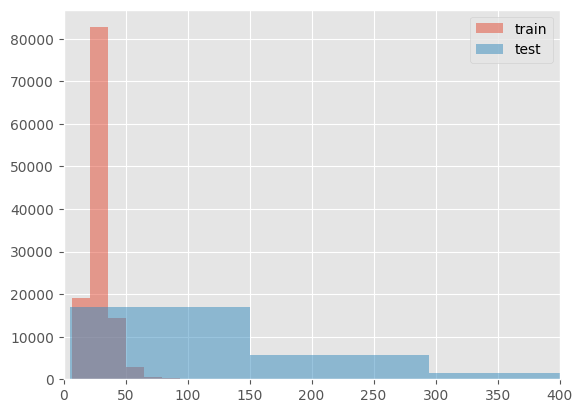

In [78]:
plt.hist(len_sequence_train, alpha=0.5, label='train')
plt.hist(len_sequence_test, alpha=0.5, label='test')
plt.xlim(0,400)
plt.legend(loc='upper right')
plt.show()

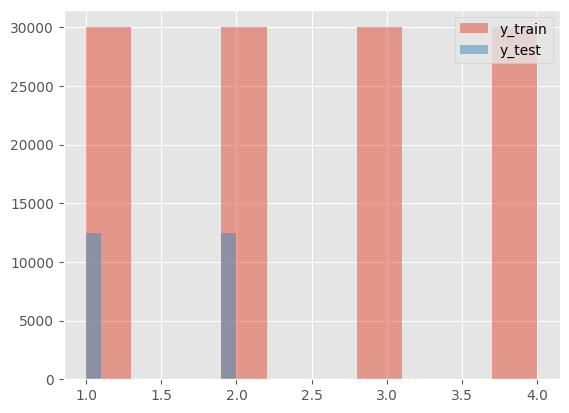

In [51]:
plt.hist(y_train, alpha=0.5, label='y_train')
plt.hist(y_test, alpha=0.5, label='y_test')

plt.legend(loc='upper right')
plt.show()

### Tokenizer

In [80]:
"""
Một số tokenizer phổ biến:
- basic_english
- spacy
- moses
- penn

"""
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer('basic_english')


In [83]:
tokenizer("Nice to meet you")

['nice', 'to', 'meet', 'you']

In [82]:
trainAfterToken = [tokenizer(text) for text in x_train]
testAfterToken = [tokenizer(text) for text in x_test]

### Vocabulary

In [85]:
from torchtext.vocab import build_vocab_from_iterator

In [88]:
vocab = build_vocab_from_iterator(iter(trainAfterToken),specials = ["<UNK>"])
vocab.set_default_index(vocab['<UNK>'])

In [92]:
print(trainAfterToken[0])
vocab(trainAfterToken[0])

['wall', 'st', '.', 'bears', 'claw', 'back', 'black', 'reuters', 'reuters', 'short', 'sellers', ',', 'wall', 'street', 'dwindling', 'band', 'ultra', 'cynics', ',', 'seeing', 'green', '.']


[349,
 280,
 1,
 1485,
 13906,
 57,
 722,
 5,
 5,
 631,
 7840,
 2,
 349,
 295,
 9773,
 2697,
 5515,
 24929,
 2,
 3821,
 667,
 1]

### DataLoader

In [99]:
text_pipeline = lambda x: vocab(x)
label_pipeline = lambda x: int(x)

In [111]:
def collate_batch(x_batch,y_batch):
    label_list, text_list, size  = [], [], [0]
    for  i in range(len(x_batch)):
        label_list.append(label_pipeline(y_batch[i]))
        processed_text = torch.tensor(text_pipeline(x_batch[i]), dtype=torch.int64)
        text_list.append(processed_text)
        size.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    size = torch.tensor(size[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return  label_list.to(device),text_list.to(device), size.to(device)

In [119]:
dataloader = DataLoader((trainAfterToken,y_train),batch_size = 16,shuffle = True ,collate_fn = collate_batch)

### Model

In [120]:
from torch import nn


class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [ ]:
num_class = len(set([label for (label, text) in train_iter]))
vocab_size = len(vocab)
emsize = 64
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

### Training

In [121]:
EPOCH = 10
LR = 1e-5
BATCH_SIZE = 64

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = LR)
total_acc = None
train_

In [ ]:
import time

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()


def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count
